In [1]:
import numpy as np
import pandas as pd

import os
import lenstronomy.Util.kernel_util as kernel_util
import lenstronomy.Util.util as util
#from astroObjectAnalyser.DataAnalysis.analysis import Analysis
from astroObjectAnalyser.astro_object_superclass import StrongLensSystem
import numpy as np
import h5py
import glob


import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import AxesGrid, make_axes_locatable

import lenstronomy

lenstronomy.__version__

import numpy as np
import os
import pickle
import copy
import time
import h5py
from pprint import pprint
import joblib
import lenstronomy.Util.util as util
from lenstronomy.Workflow.fitting_sequence import FittingSequence
from lenstronomy.Plots.model_plot import ModelPlot
from lenstronomy.Plots import chain_plot
from lenstronomy.Sampling.parameters import Param
#from lenstronomy.Analysis.lens_analysis import LensAnalysis
from lenstronomy.Util import mask_util
from lenstronomy.Data.coord_transforms import Coordinates
from lenstronomy.Util.util import array2image
cwd = os.getcwd()
base_path, _ = os.path.split(cwd)
print('Base directory path:', base_path)

import matplotlib as mpl

# for MNRAS
mpl.rcParams['ps.fonttype'] = 42

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid, make_axes_locatable
import matplotlib.image as mpimg
import seaborn as sns
import coloripy as cp

# to change tex to Times New Roman in mpl
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['mathtext.rm'] = 'serif'
plt.rcParams['mathtext.it'] = 'serif:italic'
plt.rcParams['mathtext.bf'] = 'serif:bold'
plt.rcParams['mathtext.fontset'] = 'custom'


sns.set(style='ticks', context='paper', font='Times New Roman', font_scale=2.)
#sns.set_context('talk')
sns.set_style({"xtick.direction": "in","ytick.direction": "in", "axes.linewidth": 2.0,})
#sns.set_palette('Set2')

cmap = sns.cubehelix_palette(start=0.5, rot=-1.5, gamma=1, hue=1, light=-.6, dark=0.8, reverse=False, as_cmap=True)
cmap2 = sns.cubehelix_palette(start=0.5, rot=-1.5, gamma=1, hue=1, light=-.2, dark=1., reverse=False, as_cmap=True)
#divmap = sns.diverging_palette(348., 232, s=74.35, l=42.65, as_cmap=True)
#sns.palplot(sns.diverging_palette(348., 232, s=74.35, l=42.65, as_cmap=False))

#rgb1 = np.array([59, 76, 192])
#rgb2 = np.array([180, 4, 38])

msh_cmap = cp.get_msh_cmap(num_bins=501, rescale='power', power=2.5)


Base directory path: /data/des80.b/data/chinyi/Lens_data


In [2]:
paper4_lenses = pd.read_csv('SLACS_short.csv', comment='#')
paper4_lenses = paper4_lenses.dropna()

#paper4_lenses

paper5_lenses=paper4_lenses.drop_duplicates(subset=['Short Name','Instrument','Filters'])

paper6_lenses=paper4_lenses.drop_duplicates(subset=['Short Name'])



In [3]:
Dolphin=["J0029-0055","J0037-0942","J0252+0039","J0330-0020","J0728+3835","J0737+3216","J0903+4116",
         "J0959+0410","J1112+0826","J1204+0358","J1250+0523",
         "J1306+0600","J1313+4615","J1402+6321","J1531-0105","J1621+3931",
         "J1627-0053","J1630+4520","J1636+4707","J2238-0754","J2300+0022",
         "J2303+1422","J2343-0030",]

In [4]:
def import_data(object_name,band,camera):
    cutout_dir='../SLACS/{}/{}_{}/cutout/'.format(object_name,band,camera)
    data_file = os.path.join(cutout_dir,'{}_{}.h5'.format(object_name,band))
    f = h5py.File(data_file, 'r')
    
    data_reduced = f['image_data'][()]
    background_rms = f['background_rms'][()]
    exposure_time = f['exposure_time'][()]
    ra_at_xy_0 = f['ra_at_xy_0'][()]
    dec_at_xy_0 = f['dec_at_xy_0'][()]
    transform_pix2angle = f['transform_pix2angle'][()]
    f.close()

    kwargs_data = {'image_data': data_reduced, 
                    'background_rms': background_rms,
                    'noise_map': None,
                    'exposure_time': exposure_time,
                    'ra_at_xy_0': ra_at_xy_0,
                    'dec_at_xy_0': dec_at_xy_0, 
                    'transform_pix2angle': transform_pix2angle
                    }
    return kwargs_data

In [5]:
def Preview (object_name,band,camera):
    kwargs_data_f475x = import_data(object_name,band,camera)
    
    ra_at_xy_0 = kwargs_data_f475x['ra_at_xy_0']
    dec_at_xy_0 = kwargs_data_f475x['dec_at_xy_0']
    transform_pix2angle = kwargs_data_f475x['transform_pix2angle']
    coords = Coordinates(transform_pix2angle, ra_at_xy_0, dec_at_xy_0)

# read-in the reduced cutout image
    data_cutout = kwargs_data_f475x['image_data']
    numPix = len(data_cutout)

    ax = plt.figure(figsize=(5, 5)).add_subplot(111)
    ax2=ax.matshow(np.log10(data_cutout), origin='lower', cmap=cmap, vmin=-5, vmax=1.)        
    ax.autoscale(False)

    numPixhalf=numPix
    lens_center_ra, lens_center_dec = coords.map_coord2pix(numPix/2-1, numPix/2-1)

    x_at_radec_0, y_at_radec_0 = coords.map_coord2pix(0, 0)


    lens_x, lens_y = coords.map_coord2pix(lens_center_ra, lens_center_dec)
    ax.plot(lens_x, lens_y, 'x', color='y', markersize=5)    
    plt.colorbar(ax2)
    if camera=="ACS":
        fits_dir='../SLACS/{}/{}_{}/raw_data/'.format(object_name,band,camera)    
        flc_files = glob.glob(fits_dir+'/*flc.fits')
        ACS_Num=(len(flc_files))   
        if ACS_Num==1:
            plt.title("{}-{}-s".format(band,camera))
        else:
            plt.title("{}-{}".format(band,camera))
    else:    
        plt.title("{}-{}".format(band,camera))
    plt.show()

In [6]:
def Preview2 (object_name,band,camera,num):
  #  print(band,camera)

    kwargs_data_f475x = import_data(object_name,band,camera)
    
    ra_at_xy_0 = kwargs_data_f475x['ra_at_xy_0']
    dec_at_xy_0 = kwargs_data_f475x['dec_at_xy_0']
    transform_pix2angle = kwargs_data_f475x['transform_pix2angle']
    coords = Coordinates(transform_pix2angle, ra_at_xy_0, dec_at_xy_0)

# read-in the reduced cutout image
    data_cutout = kwargs_data_f475x['image_data']
    numPix = len(data_cutout)

    #ax[num] = plt.figure(figsize=(5, 5)).add_subplot(111)
    ax2=ax[num].matshow(np.log10(data_cutout), origin='lower', cmap=cmap, vmin=-5, vmax=1.)
    ax[num].autoscale(False)

    numPixhalf=numPix
    lens_center_ra, lens_center_dec = coords.map_coord2pix(numPix/2-1, numPix/2-1)
    

    x_at_radec_0, y_at_radec_0 = coords.map_coord2pix(0, 0)


    lens_x, lens_y = coords.map_coord2pix(lens_center_ra, lens_center_dec)
    ax[num].plot(lens_x, lens_y, 'x', color='y', markersize=5)  
    
    if camera=="ACS":
        fits_dir='../SLACS/{}/{}_{}/raw_data/'.format(object_name,band,camera)    
        flc_files = glob.glob(fits_dir+'/*flc.fits')
        ACS_Num=(len(flc_files))    
        if ACS_Num==1:
            ax[num].title.set_text("{}-{}-s".format(band,camera))
        else:
            ax[num].title.set_text("{}-{}".format(band,camera))
    else:    
        ax[num].title.set_text("{}-{}".format(band,camera))
    return ax2
    


2. SDSSJ0029-0055,  Dolphin No.1


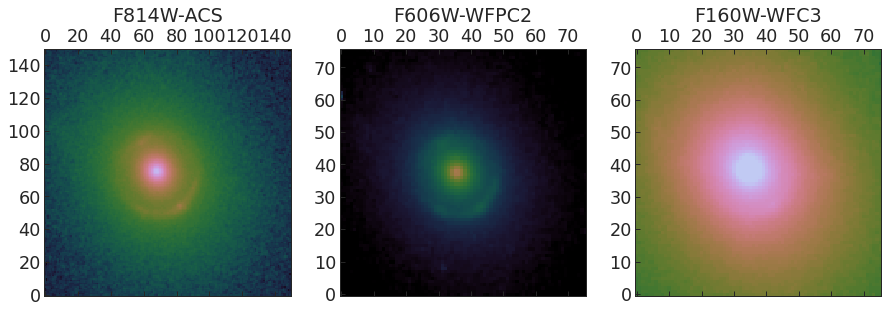

3. SDSSJ0037-0942,  Dolphin No.2


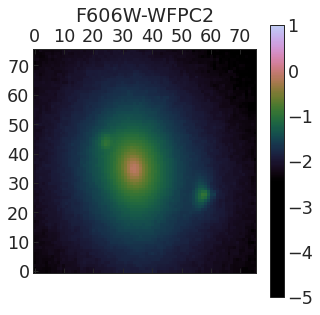

8. SDSSJ0252+0039,  Dolphin No.3


/home/s1/chinyi/.conda/envs/astroconda/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in log10
  app.launch_new_instance()


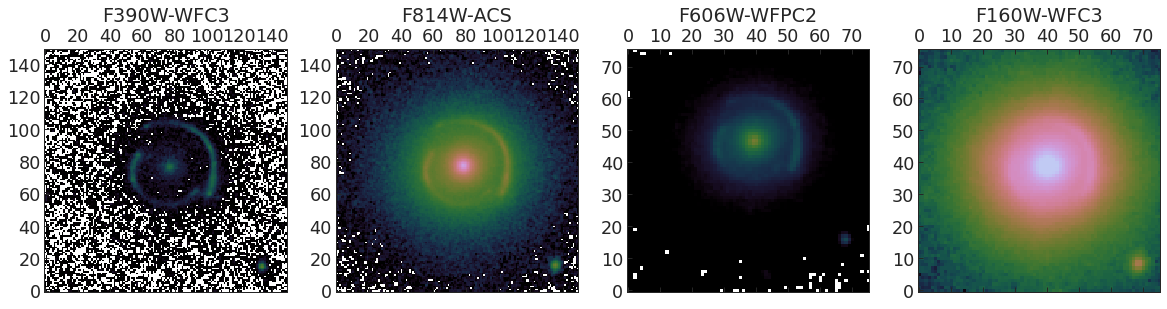

9. SDSSJ0330-0020,  Dolphin No.4


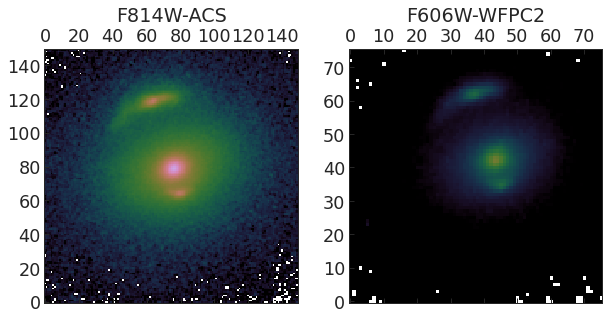

11. SDSSJ0728+3835,  Dolphin No.5


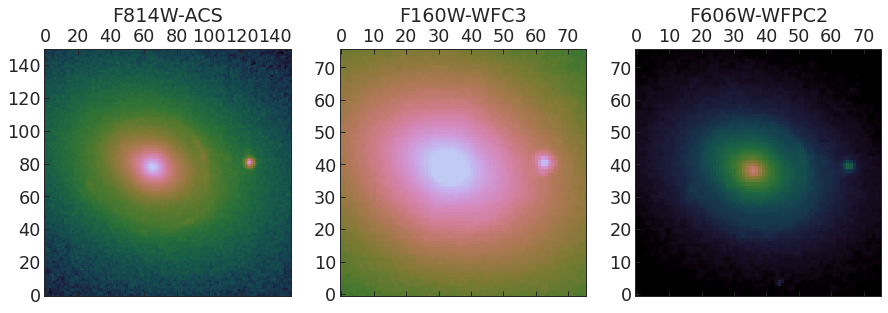

12. SDSSJ0737+3216,  Dolphin No.6


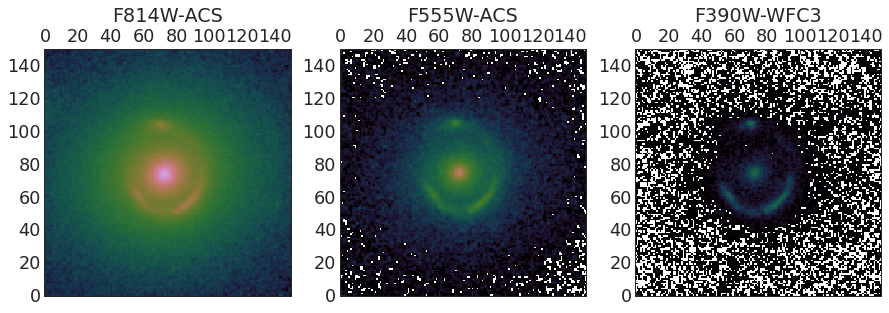

17. SDSSJ0903+4116,  Dolphin No.7


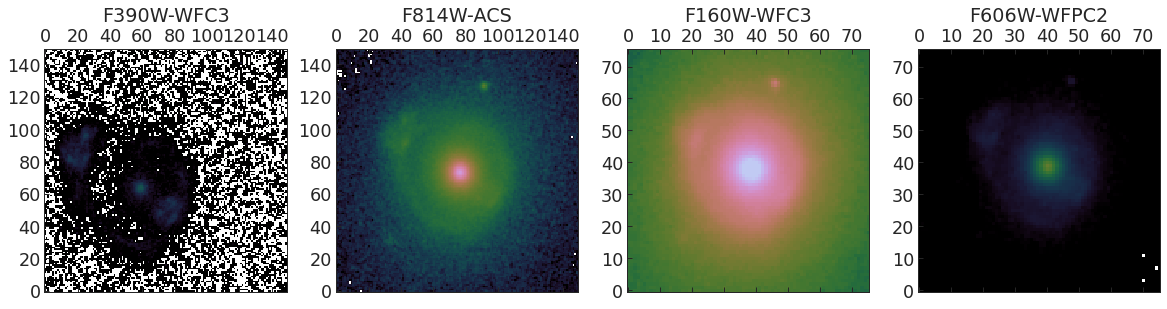

24. SDSSJ0959+0410,  Dolphin No.8


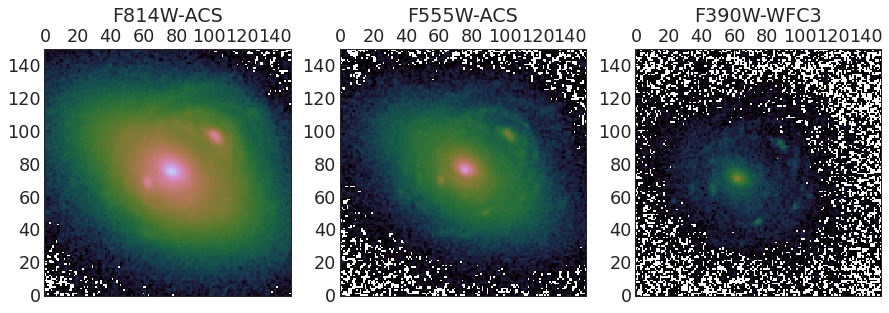

35. SDSSJ1112+0826,  Dolphin No.9


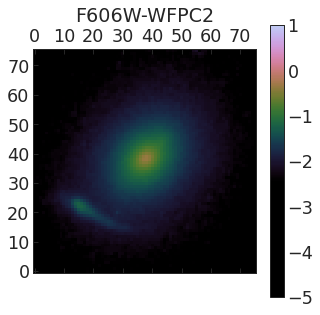

40. SDSSJ1204+0358,  Dolphin No.10


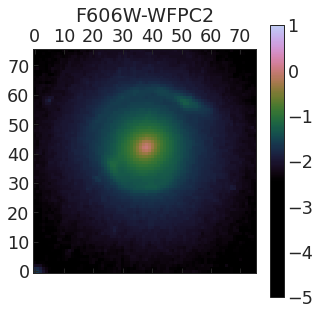

45. SDSSJ1250+0523,  Dolphin No.11


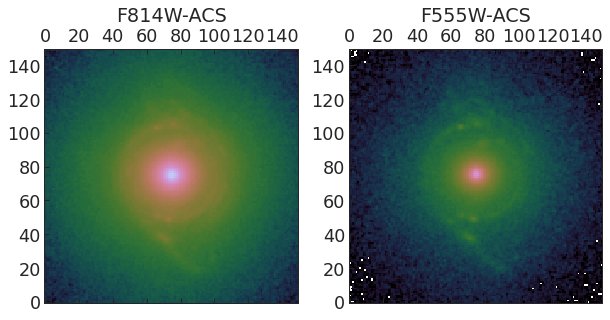

48. SDSSJ1306+0600,  Dolphin No.12


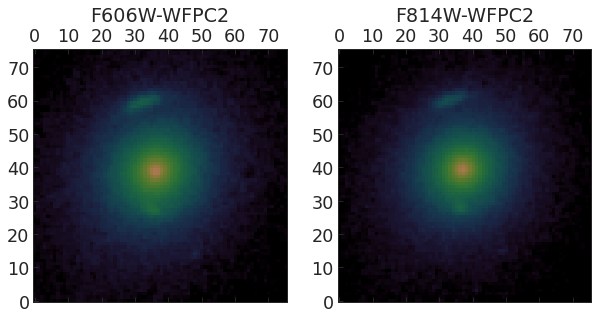

50. SDSSJ1313+4615,  Dolphin No.13


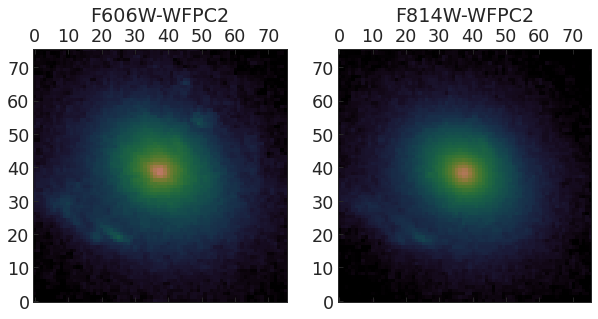

54. SDSSJ1402+6321,  Dolphin No.14


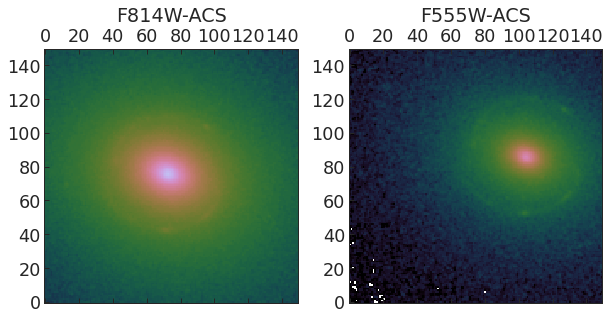

65. SDSSJ1531-0105,  Dolphin No.15


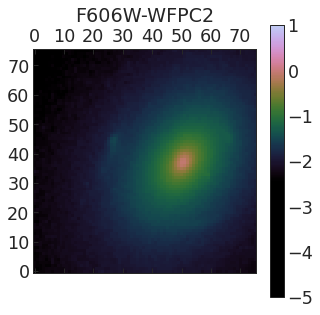

69. SDSSJ1621+3931,  Dolphin No.16


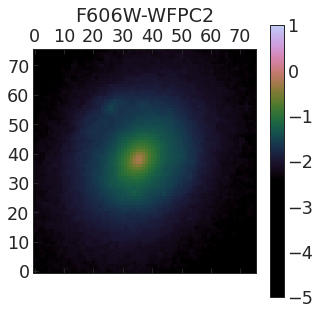

70. SDSSJ1627-0053,  Dolphin No.17


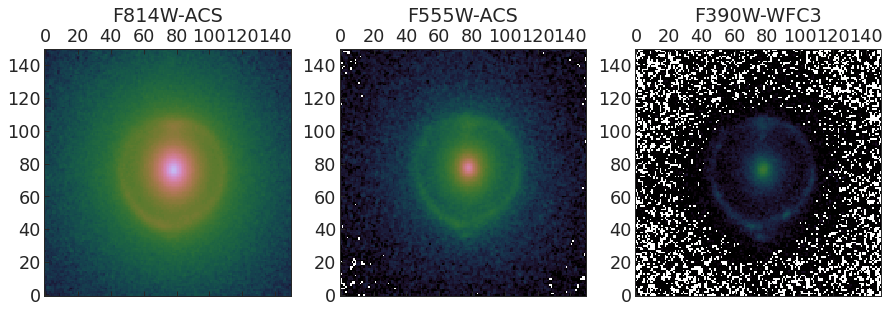

71. SDSSJ1630+4520,  Dolphin No.18


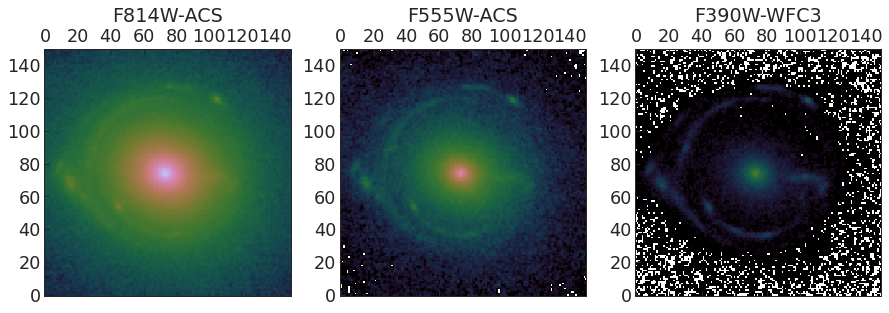

72. SDSSJ1636+4707,  Dolphin No.19


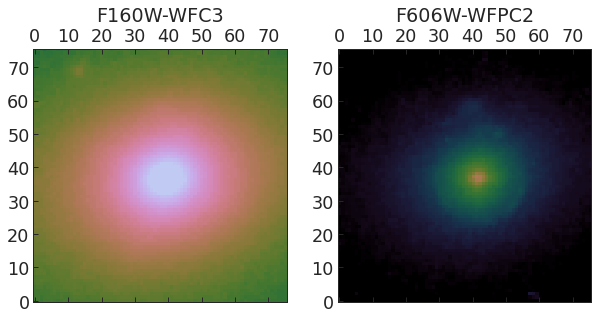

78. SDSSJ2238-0754,  Dolphin No.20


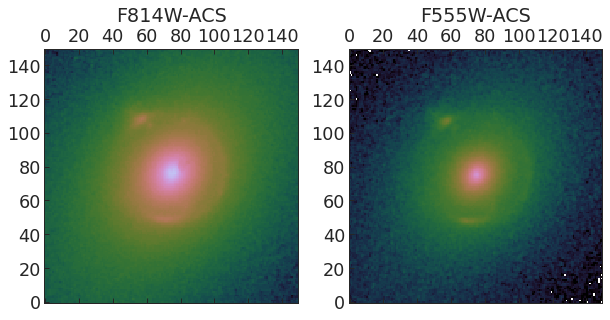

79. SDSSJ2300+0022,  Dolphin No.21


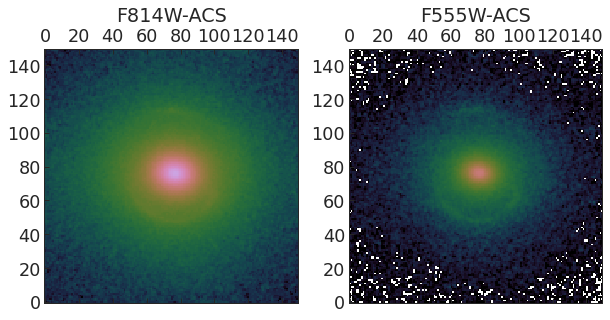

81. SDSSJ2303+1422,  Dolphin No.22


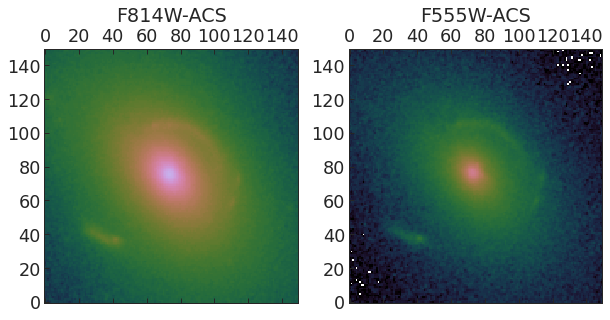

84. SDSSJ2343-0030,  Dolphin No.23


/home/s1/chinyi/.conda/envs/astroconda/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  


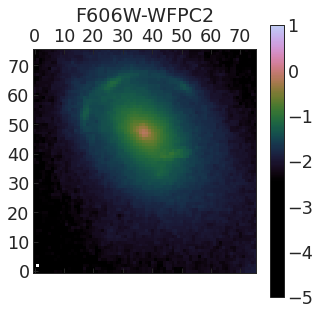

In [9]:
%matplotlib inline

lens_num=1
dolphin_num=1

show_dolphin = True

for index, row in paper6_lenses.iterrows():
    total_num=0
    num=0
    
    uni_row=row['Short Name']
    
    if show_dolphin:
        if row['Short Name'][4:] in Dolphin:
            print(str(lens_num)+". "+uni_row+",  Dolphin No." +str(dolphin_num))
            dolphin_num+=1
            lens_num+=1
        else:
            lens_num+=1
            continue
            print(str(lens_num)+". "+uni_row)
            
    else:
        if row['Short Name'][4:] in Dolphin:
            print(str(lens_num)+". "+uni_row+",  Dolphin No." +str(dolphin_num))
            dolphin_num+=1
            lens_num+=1
        else:
            print(str(lens_num)+". "+uni_row)
            lens_num+=1    
    
    for index, row in paper5_lenses.iterrows():
        if row['Short Name']==uni_row and row['Instrument']!="NICMOS" and  row['Instrument']!="ACS-s":
            total_num+=1
   
    if total_num ==0:
        print("All lenses are single exposure ACS")

    elif total_num == 1:
        for index, row in paper5_lenses.iterrows():
            if row['Short Name']==uni_row and row['Instrument']!="NICMOS" and  row['Instrument']!="ACS-s":
                Preview(row['Short Name'],row['Filters'],row['Instrument'])            
            
    else:        
        
        fig, ax = plt.subplots(1, total_num,figsize=(5*total_num,5*total_num))

        for index, row in paper5_lenses.iterrows():
            if row['Short Name']==uni_row and row['Instrument']!="NICMOS" and  row['Instrument']!="ACS-s" :   
                Preview2(row['Short Name'],row['Filters'],row['Instrument'],num)
                num+=1
                    
        plt.show()
